## Decision Tree Classifier for Customer Churn Prediction

This notebook implements a Decision Tree Classifier to predict customer churn.
The goal is to:
- Capture non-linear feature interactions
- Maintain interpretability

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

RANDOM_STATE = 42


In [12]:
#Load & Schema Fix
df = pd.read_csv("../dataset/telco_train.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop(columns=["Churn", "customerID"], errors="ignore")
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

In [13]:
df["Churn"].value_counts(normalize=True)
df.shape
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5634 non-null   object 
 1   SeniorCitizen     5634 non-null   int64  
 2   Partner           5634 non-null   object 
 3   Dependents        5634 non-null   object 
 4   tenure            5634 non-null   int64  
 5   PhoneService      5634 non-null   object 
 6   MultipleLines     5634 non-null   object 
 7   InternetService   5634 non-null   object 
 8   OnlineSecurity    5634 non-null   object 
 9   OnlineBackup      5634 non-null   object 
 10  DeviceProtection  5634 non-null   object 
 11  TechSupport       5634 non-null   object 
 12  StreamingTV       5634 non-null   object 
 13  StreamingMovies   5634 non-null   object 
 14  Contract          5634 non-null   object 
 15  PaperlessBilling  5634 non-null   object 
 16  PaymentMethod     5634 non-null   object 


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,No
1,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,No
2,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,No
3,Female,0,Yes,No,26,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,No
4,Male,0,Yes,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,No


In [18]:
# Fix TotalCharges issue
# Fix TotalCharges issue
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df["TotalCharges"].isnull().sum()

df["TotalCharges"] = df["TotalCharges"].fillna(
    df["TotalCharges"].median()
)



binary_cols = [
    col for col in df.columns
    if df[col].nunique() == 2 and df[col].dtype == "object"
]

binary_cols.remove("Churn")


In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])


In [20]:
multi_cols = [
    col for col in df.columns
    if df[col].dtype == "object" and col != "Churn"
]
df = pd.get_dummies(df, columns=multi_cols, drop_first=True)


In [21]:

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

In [22]:
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes": 1, "No": 0})
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [38]:
dt_clf = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight={0:1, 1:2}
)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)
y_proba = dt_clf.predict_proba(X_test)[:, 1]


In [39]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy : 0.7426796805678794
Precision: 0.5152542372881356
Recall   : 0.5083612040133779
F1 Score : 0.5117845117845118
ROC AUC  : 0.6675310616709483

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       828
           1       0.52      0.51      0.51       299

    accuracy                           0.74      1127
   macro avg       0.67      0.67      0.67      1127
weighted avg       0.74      0.74      0.74      1127



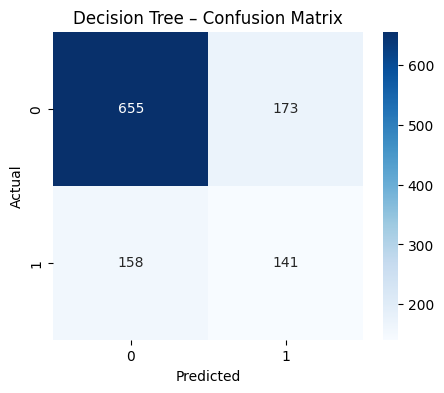

In [31]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.show()


In [32]:
train_score = dt_clf.score(X_train, y_train)
test_score = dt_clf.score(X_test, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy : {test_score:.4f}")


Training Accuracy: 0.9982
Testing Accuracy : 0.7063


In [41]:
param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight={0: 1, 1: 2}
    ),
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [42]:
best_dt = grid.best_estimator_

y_pred_best = best_dt.predict(X_test)
y_proba_best = best_dt.predict_proba(X_test)[:, 1]

print("ROC AUC (Tuned):", roc_auc_score(y_test, y_proba_best))


ROC AUC (Tuned): 0.8333757452377489


In [43]:
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": best_dt.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance.head(10)


,feature,importance
26,Contract_Two year,0.382212
25,Contract_One year,0.255895
11,InternetService_Fiber optic,0.131596
4,tenure,0.120576
7,MonthlyCharges,0.034701
24,StreamingMovies_Yes,0.025681
8,TotalCharges,0.022603
28,PaymentMethod_Electronic check,0.022588
5,PhoneService,0.001874
16,OnlineBackup_Yes,0.001535


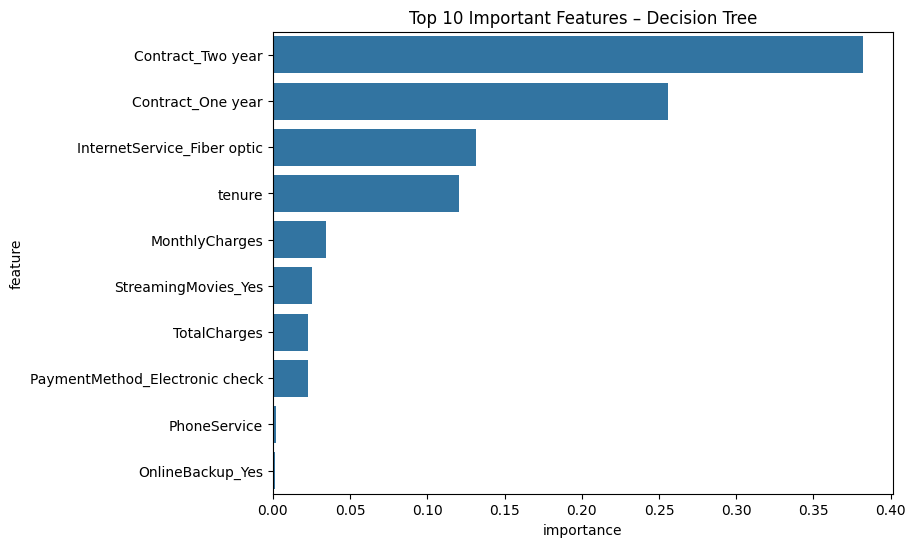

In [44]:
plt.figure(figsize=(8,6))
sns.barplot(
    x="importance",
    y="feature",
    data=feature_importance.head(10)
)
plt.title("Top 10 Important Features – Decision Tree")
plt.show()


In [45]:
y_pred_tuned = best_dt.predict(X_test)
y_proba_tuned = best_dt.predict_proba(X_test)[:, 1]


In [46]:
print("Tuned ROC AUC:",
      roc_auc_score(y_test, y_proba_tuned))

print("\nTuned Classification Report:\n")
print(classification_report(y_test, y_pred_tuned))


Tuned ROC AUC: 0.8333757452377489

Tuned Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       828
           1       0.56      0.71      0.62       299

    accuracy                           0.77      1127
   macro avg       0.72      0.75      0.73      1127
weighted avg       0.80      0.77      0.78      1127



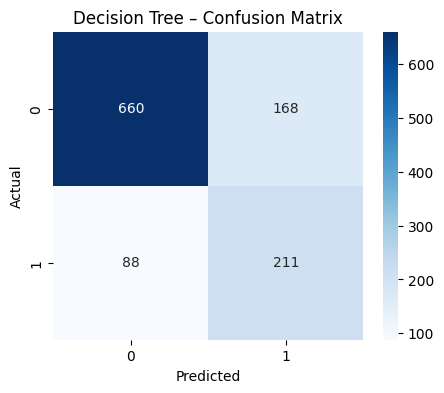

In [47]:
cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.show()


In [48]:
from sklearn.metrics import roc_auc_score

# Training predictions
y_train_pred = best_dt.predict(X_train)
y_train_proba = best_dt.predict_proba(X_train)[:, 1]

# Test predictions
y_test_pred = best_dt.predict(X_test)
y_test_proba = best_dt.predict_proba(X_test)[:, 1]

print("TRAIN PERFORMANCE")
print("Train Accuracy :", best_dt.score(X_train, y_train))
print("Train ROC AUC  :", roc_auc_score(y_train, y_train_proba))

print("\nTEST PERFORMANCE")
print("Test Accuracy  :", best_dt.score(X_test, y_test))
print("Test ROC AUC   :", roc_auc_score(y_test, y_test_proba))


TRAIN PERFORMANCE
Train Accuracy : 0.7792323053028622
Train ROC AUC  : 0.846113189136445

TEST PERFORMANCE
Test Accuracy  : 0.7728482697426797
Test ROC AUC   : 0.8333757452377489


In [49]:
import joblib

joblib.dump(best_dt, "../models/decision_tree_churn_model.pkl")

['../models/decision_tree_churn_model.pkl']